In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports, constants and paths

In [ ]:
import pathlib
from pathlib import Path
import pandas as pd
import PIL
from PIL import Image, ExifTags, ImageOps
from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import ast
import json
from scipy import signal
import os
from collections import defaultdict
import random

In [ ]:
root_directory = "/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/"
plots = root_directory + '/plots'
collected_data = root_directory + "data/"
downloaded_data = root_directory + "BAZA_Z_NETA/"
final_data = root_directory + "finaldata/"
preprocessed_data = root_directory + "preprocessed_data/"

In [ ]:
dataset_url = root_directory
collected_data_dir = pathlib.Path(collected_data)
downloaded_data_dir = pathlib.Path(downloaded_data)
final_data_dir = pathlib.Path(final_data)

collected_data_dir, downloaded_data_dir, final_data_dir

(PosixPath('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/data'),
 PosixPath('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/BAZA_Z_NETA'),
 PosixPath('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/finaldata'))

### Statistics about data (number of images, number of examples, class names and number of classes)

In [ ]:
print("Collected data")
image_count = len(list(collected_data_dir.glob('*/*.jpg')))
print("jpg images: ", image_count)
image_count = len(list(collected_data_dir.glob('*/*.*')))
print("all images: ", image_count)

print("Downloaded data")
image_count = len(list(downloaded_data_dir.glob('*/*.jpg')))
print("jpg images: ", image_count)
image_count = len(list(downloaded_data_dir.glob('*/*.*')))
print("all images: ", image_count)

Collected data
jpg images:  736
all images:  736
Downloaded data
jpg images:  7428
all images:  7980


In [ ]:
collected_images = []
downloaded_images = []
class_names = ['bicycle', 'bus', 'car', 'motorcycle', 'truck', 'TRUDNOSC_Z_PRZYPISANIEM']

print("Number of images for particular classes collected by hand")
for class_name in class_names:
  dir = class_name + '/*.jpg'
  image_count = len(list(collected_data_dir.glob(dir)))
  collected_images.append(image_count)
  print(class_name, ':', image_count)

print()
print("Number of images for particular classes downloaded online")
for class_name in class_names:
  dir = class_name + '/*.*'
  image_count = len(list(downloaded_data_dir.glob(dir)))
  downloaded_images.append(image_count)
  print(class_name, ':', image_count)

Number of images for particular classes collected by hand
bicycle : 66
bus : 46
car : 488
motorcycle : 50
truck : 69
TRUDNOSC_Z_PRZYPISANIEM : 17

Number of images for particular classes downloaded online
bicycle : 365
bus : 1059
car : 3045
motorcycle : 2487
truck : 1024
TRUDNOSC_Z_PRZYPISANIEM : 0


In [ ]:
df = pd.DataFrame(class_names, columns=['class_name'])
df['collected_images'] = collected_images
df['downloaded_images'] = downloaded_images
df['sum_of_images_in_the_class'] = df.collected_images + df.downloaded_images
display(df)
print()
print("Total sum of all images (collected + downloaded): ", sum(df['sum_of_images_in_the_class']))
print("Total sum of collected images: ", sum(df['collected_images']))
print("Total sum of downloaded images : ", sum(df['downloaded_images']))

,class_name,collected_images,downloaded_images,sum_of_images_in_the_class
0,bicycle,66,365,431
1,bus,46,1059,1105
2,car,488,3045,3533
3,motorcycle,50,2487,2537
4,truck,69,1024,1093
5,TRUDNOSC_Z_PRZYPISANIEM,17,0,17



Total sum of all images (collected + downloaded):  8716
Total sum of collected images:  736
Total sum of downloaded images :  7980


### Data agregation to one final folder finaldata
(initially without any changes to the files, we collect data about the photos)
- There is a need to flip photos using image orientation tag. If you're using Pillow >= 6.0.0, you can use the built-in ImageOps.exif_transpose function do correctly rotate an image according to its exif tag:
- https://stackoverflow.com/questions/13872331/rotating-an-image-with-orientation-specified-in-exif-using-python-without-pil-in
- However, in our case it did not worked - we used getexif() function and then {ExifTags.TAGS[key]}:{val} dictionary

SCRIPT EXECUTION TIME
- START: 14:58
- END: 15:10

In [ ]:
class_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']
images_names_list = list()
images_modes_list = list()
images_formats_list = list()
images_sizes_list = list()
images_red_pixels_list = list()
images_green_pixels_list = list()
images_blue_pixels_list = list()
images_sources_list = list()
metadata_datetime_list = list()
metadata_resolutionunit_list = list()
metadata_Xresolution_list = list()
metadata_Yresolution_list = list()
metadata_brightnessvalue_list = list()
metadata_aperturevalue_list = list()
metadata_phonemake_list = list()
metadata_phonemodel_list = list()
metadata_ISOspeedratings_list = list()
metadata_flash_list = list()
metadata_focallength_list = list()
metadata_sensingmethod_list = list()

for class_name in class_names:
  #each class starts id from 0
  imageid = 0
  #paths
  imageCollectedFilePath = Path.joinpath(collected_data_dir, class_name)
  imageDownloadedFilePath = Path.joinpath(downloaded_data_dir, class_name)
  imageFinalFilePath = Path.joinpath(final_data_dir, class_name)
  #collect images from first source
  for imagePath in list(imageCollectedFilePath.glob('*.*')):
    image = Image.open(imagePath) # loads image (as pd.read_image())
    # save in the same format
    image_name = class_name + str(imageid)
    image_mode = image.mode
    image_format = image.format
    image_size = image.size
    image_source = 'collected'
    pixels = image.histogram()
    red_pixels = pixels[0:256]      # indicates Red
    green_pixels = pixels[256:512]  # indicated Green
    blue_pixels = pixels[512:768]   # indicates Blue
    #print(image_name, image_mode, image_format, image_size, red_pixels, green_pixels, blue_pixels)
    #SAVE IMAGES DATA
    images_names_list.append(image_name)
    images_modes_list.append(image_mode)
    images_formats_list.append(image_format)
    images_sizes_list.append(image_size)
    images_red_pixels_list.append(red_pixels)
    images_green_pixels_list.append(green_pixels)
    images_blue_pixels_list.append(blue_pixels)
    images_sources_list.append(image_source)
    
    #ROTATE IMAGE IF NECESSARY USING ORIENTATION TAG
    # print('image before rotating')
    # plt.imshow(image)
    # plt.show()
    #rotate if necessary using orientation tags
    #image = ImageOps.exif_transpose(image)
    img_exif = image.getexif()
    if bool(img_exif) == False:
      metadata_datetime = ''
      metadata_resolutionunit = ''
      metadata_Xresolution = ''
      metadata_Yresolution = ''
      metadata_brightnessvalue = ''
      metadata_aperturevalue = ''
      metadata_phonemake = ''
      metadata_phonemodel = ''
      metadata_ISOspeedratings = ''
      metadata_flash = ''
      metadata_focallength = ''
      metadata_sensingmethod = ''
      #print('Sorry, image has no exif data.')
    else:
      for key, val in img_exif.items():
        #rotate if necessary using orientation tags
        if key == 274 and val == 3:
          image = image.rotate(180, expand=True)
        elif key == 274 and val == 6:
          image = image.rotate(270, expand=True)
        elif key == 274 and val == 8:
          image = image.rotate(90, expand=True)
        #EXTRACT METADATA FROM TAGS
        #datetime
        if key == 306:
          metadata_datetime = val
        if 306 not in img_exif.keys():
          metadata_datetime = ''
        #metadata_resolutionunit
        if key == 296:
          metadata_resolutionunit = val
        if 296 not in img_exif.keys():
          metadata_resolutionunit = ''
        #metadata_Xresolution
        if key == 282:
          metadata_Xresolution = val
        if 282 not in img_exif.keys():
          metadata_Xresolution = ''
        #metadata_Yresolution
        if key == 283:
          metadata_Yresolution = val
        if 283 not in img_exif.keys():
          metadata_Yresolution = ''
        #metadata_brightnessvalue
        if key == 37379:
          metadata_brightnessvalue = val
        if 37379 not in img_exif.keys():
          metadata_brightnessvalue = ''
        #metadata_aperturevalue
        if key == 37378:
          metadata_aperturevalue = val
        if 37378 not in img_exif.keys():
          metadata_aperturevalue = ''
        #metadata_phonemake
        if key == 271:
          metadata_phonemake = val
        if 271 not in img_exif.keys():
          metadata_phonemake = ''
        #metadata_phonemodel
        if key == 272:
          metadata_phonemodel = val
        if 272 not in img_exif.keys():
          metadata_phonemodel = ''
        #metadata_ISOspeedratings
        if key == 34855:
          metadata_ISOspeedratings = val
        if 34855 not in img_exif.keys():
          metadata_ISOspeedratings = ''
        #metadata_flash
        if key == 37385:
          metadata_flash = val
        if 37385 not in img_exif.keys():
          metadata_flash = ''
        #metadata_focallength
        if key == 37386:
          metadata_focallength = val
        if 37386 not in img_exif.keys():
          metadata_focallength = ''
        #metadata_sensingmethod
        if key == 41495:
          metadata_sensingmethod = val
        if 41495 not in img_exif.keys():
          metadata_sensingmethod = ''

        #if ExifTags.TAGS[key] == 'Orientation':
        #  print(key) #274 is the key to the 'Orientation" TAG
        #print(f'{ExifTags.TAGS[key]}:{val}')
    # print(img_exif)
    # print(type(img_exif))
    # print('image after rotating')
    # plt.imshow(image)
    # plt.show()

    #SAVE IMAGES METADATA
    metadata_datetime_list.append(metadata_datetime)
    metadata_resolutionunit_list.append(metadata_resolutionunit)
    metadata_Xresolution_list.append(metadata_Xresolution)
    metadata_Yresolution_list.append(metadata_Yresolution)
    metadata_brightnessvalue_list.append(metadata_brightnessvalue)
    metadata_aperturevalue_list.append(metadata_aperturevalue)
    metadata_phonemake_list.append(metadata_phonemake)
    metadata_phonemodel_list.append(metadata_phonemodel)
    metadata_ISOspeedratings_list.append(metadata_ISOspeedratings)
    metadata_flash_list.append(metadata_flash)
    metadata_focallength_list.append(metadata_focallength)
    metadata_sensingmethod_list.append(metadata_sensingmethod)

    #SAVE IMAGE
    image.save(Path.joinpath(imageFinalFilePath, f'{image_name}.{str(image_format)}'), format=image_format)
    #remember to increment image_id
    imageid += 1
    #optionally - show image
    if imageid % 250 == 0:
      plt.imshow(image)
      plt.show()
    #CLOSE IMAGE (necessary to release memory, because load() function were not called)
    image.close()
    ### TO DELETE!! ## 
    # if imageid > 2:
    #   break

  #collect images from second source (internet database) 
  for imagePath in list(imageDownloadedFilePath.glob('*.*')):
      image = Image.open(imagePath) # ładuje zdjęcie (jak pd.read_image())
      # save in the same format
      image_name = class_name + str(imageid)
      image_mode = image.mode
      image_format = image.format
      image_size = image.size
      image_source = 'downloaded'
      pixels = image.histogram()
      red_pixels = pixels[0:256]      # indicates Red
      green_pixels = pixels[256:512]  # indicated Green
      blue_pixels = pixels[512:768]   # indicates Blue
      #print(image_name, image_mode, image_format, image_size, red_pixels, green_pixels, blue_pixels)
      #SAVE IMAGES DATA
      images_names_list.append(image_name)
      images_modes_list.append(image_mode)
      images_formats_list.append(image_format)
      images_sizes_list.append(image_size)
      images_red_pixels_list.append(red_pixels)
      images_green_pixels_list.append(green_pixels)
      images_blue_pixels_list.append(blue_pixels)
      images_sources_list.append(image_source)

      #ROTATE IMAGE IF NECESSARY USING ORIENTATION TAG
      # print('image before rotating')
      # plt.imshow(image)
      # plt.show()
      #rotate if necessary using orientation tags
      #image = ImageOps.exif_transpose(image)
      img_exif = image.getexif()
      if bool(img_exif) == False:
        metadata_datetime = ''
        metadata_resolutionunit = ''
        metadata_Xresolution = ''
        metadata_Yresolution = ''
        metadata_brightnessvalue = ''
        metadata_aperturevalue = ''
        metadata_phonemake = ''
        metadata_phonemodel = ''
        metadata_ISOspeedratings = ''
        metadata_flash = ''
        metadata_focallength = ''
        metadata_sensingmethod = ''
        #print('Sorry, image has no exif data.')
      else:
        for key, val in img_exif.items():
          #rotate if necessary using orientation tags
          if key == 274 and val == 3:
            image = image.rotate(180, expand=True)
          elif key == 274 and val == 6:
            image = image.rotate(270, expand=True)
          elif key == 274 and val == 8:
            image = image.rotate(90, expand=True)
          #EXTRACT METADATA FROM TAGS
          #datetime
          if key == 306:
            metadata_datetime = val
          if 306 not in img_exif.keys():
            metadata_datetime = ''
          #metadata_resolutionunit
          if key == 296:
            metadata_resolutionunit = val
          if 296 not in img_exif.keys():
            metadata_resolutionunit = ''
          #metadata_Xresolution
          if key == 282:
            metadata_Xresolution = val
          if 282 not in img_exif.keys():
            metadata_Xresolution = ''
          #metadata_Yresolution
          if key == 283:
            metadata_Yresolution = val
          if 283 not in img_exif.keys():
            metadata_Yresolution = ''
          #metadata_brightnessvalue
          if key == 37379:
            metadata_brightnessvalue = val
          if 37379 not in img_exif.keys():
            metadata_brightnessvalue = ''
          #metadata_aperturevalue
          if key == 37378:
            metadata_aperturevalue = val
          if 37378 not in img_exif.keys():
            metadata_aperturevalue = ''
          #metadata_phonemake
          if key == 271:
            metadata_phonemake = val
          if 271 not in img_exif.keys():
            metadata_phonemake = ''
          #metadata_phonemodel
          if key == 272:
            metadata_phonemodel = val
          if 272 not in img_exif.keys():
            metadata_phonemodel = ''
          #metadata_ISOspeedratings
          if key == 34855:
            metadata_ISOspeedratings = val
          if 34855 not in img_exif.keys():
            metadata_ISOspeedratings = ''
          #metadata_flash
          if key == 37385:
            metadata_flash = val
          if 37385 not in img_exif.keys():
            metadata_flash = ''
          #metadata_focallength
          if key == 37386:
            metadata_focallength = val
          if 37386 not in img_exif.keys():
            metadata_focallength = ''
          #metadata_sensingmethod
          if key == 41495:
            metadata_sensingmethod = val
          if 41495 not in img_exif.keys():
            metadata_sensingmethod = ''
          #if ExifTags.TAGS[key] == 'Orientation':
          #  print(key) #274 is the key to the 'Orientation" TAG
          #print(f'{ExifTags.TAGS[key]}:{val}')
      # print(img_exif)
      # print(type(img_exif))
      # print('image after rotating')
      # plt.imshow(image)
      # plt.show()

      #SAVE IMAGES METADATA
      metadata_datetime_list.append(metadata_datetime)
      metadata_resolutionunit_list.append(metadata_resolutionunit)
      metadata_Xresolution_list.append(metadata_Xresolution)
      metadata_Yresolution_list.append(metadata_Yresolution)
      metadata_brightnessvalue_list.append(metadata_brightnessvalue)
      metadata_aperturevalue_list.append(metadata_aperturevalue)
      metadata_phonemake_list.append(metadata_phonemake)
      metadata_phonemodel_list.append(metadata_phonemodel)
      metadata_ISOspeedratings_list.append(metadata_ISOspeedratings)
      metadata_flash_list.append(metadata_flash)
      metadata_focallength_list.append(metadata_focallength)
      metadata_sensingmethod_list.append(metadata_sensingmethod)

      #SAVE IMAGE
      image.save(Path.joinpath(imageFinalFilePath, f'{image_name}.{str(image_format)}'), format=image_format)
      #remember to increment image_id
      imageid += 1
      #optionally - show image
      if imageid % 250 == 0:
        plt.imshow(image)
        plt.show()
      #CLOSE IMAGE (necessary to release memory, because load() function were not called)
      image.close()
      # if imageid > 6:
      #   break

#after all iterations
data_dictionary = {'name': images_names_list, 
                   'mode': images_modes_list, 
                   'format': images_formats_list, 
                   'size': images_sizes_list, 
                   'R': images_red_pixels_list, 
                   'G': images_green_pixels_list, 
                   'B': images_blue_pixels_list, 
                   'source': images_sources_list,
                   'datetime': metadata_datetime_list, 
                   'resolutionUnit': metadata_resolutionunit_list, 
                   'Xresolution': metadata_Xresolution_list, 
                   'Yresolution': metadata_Yresolution_list, 
                   'brightness': metadata_brightnessvalue_list, 
                   'aperture': metadata_aperturevalue_list, 
                   'phonemake': metadata_phonemake_list, 
                   'phonemodel': metadata_phonemodel_list, 
                   'ISOspeedratings': metadata_ISOspeedratings_list, 
                   'flash': metadata_flash_list, 
                   'focallength': metadata_focallength_list, 
                   'sensingmethod': metadata_sensingmethod_list}
df = pd.DataFrame(data_dictionary)
display(df)

Output hidden; open in https://colab.research.google.com to view.

##### Save resulting dataframe to CSV file

In [ ]:
df.to_csv(root_directory+'imagesmetadata2.csv')

##### Extract metadata from picture

In [ ]:
# image from finaldata
image = Image.open('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/BAZA_Z_NETA/motorcycle/ZYM0ZRZ2MA9K.jpg')
img_exif = image.getexif()
print(img_exif)
if bool(img_exif) == False:
  metadata_datetime = ''
  print('Sorry, image has no exif data.')
id = None
print('TAG:value:key')
for key, val in img_exif.items():
  print(f'{ExifTags.TAGS[key]}:{val}:{key}')
print("working", id)

{}
Sorry, image has no exif data.
TAG:value:key
working None


In [ ]:
image = Image.open('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/data/motorcycle/IMG_20220328_151748.jpg')
img_exif = image.getexif()
print('TAG:value:key')
for key, val in img_exif.items():
  print(f'{ExifTags.TAGS[key]}:{val}:{key}')
  # if key == 274 and val == 3:
  #   image = image.rotate(180, expand=True)
  # elif key == 274 and val == 6:
  #   image = image.rotate(270, expand=True)
  # elif key == 274 and val == 8:
  #   image = image.rotate(90, expand=True)
  #TODO: EXTRACT METADATA FROM TAGS
  #if ExifTags.TAGS[key] == 'Orientation':
  #  print(key) #274 is the key to the 'Orientation" TAG

TAG:value:key
ExifVersion:b'0220':36864
ComponentsConfiguration:b'\x01\x02\x03\x00':37121
ShutterSpeedValue:(10633, 1000):37377
DateTimeOriginal:2022:03:28 15:17:48:36867
DateTimeDigitized:2022:03:28 15:17:48:36868
ApertureValue:(169, 100):37378
BrightnessValue:(416, 100):37379
MeteringMode:1:37383
FlashPixVersion:b'0100':40960
Flash:24:37385
FocalLength:(3820, 1000):37386
ColorSpace:1:40961
ExifImageWidth:2976:40962
ExifInteroperabilityOffset:713:40965
FocalLengthIn35mmFilm:27:41989
SceneCaptureType:0:41990
ExifImageHeight:2976:40963
Make:Xiaomi:271
Model:Mi Note 3:272
Orientation:6:274
YCbCrPositioning:1:531
SensingMethod:2:41495
XResolution:(72, 1):282
YResolution:(72, 1):283
SceneType:b'\x01':41729
ExposureProgram:0:34850
GPSInfo:{}:34853
ISOSpeedRatings:275:34855
ResolutionUnit:2:296
ExposureMode:0:41986
WhiteBalance:0:41987
Software:jason-user 9 PKQ1.181007.001 V12.0.1.0.PCHMIXM release-keys:305
DateTime:2022:03:28 15:17:48:306
ExifOffset:260:34665
SubsecTime:778237:37520
SubsecT

The tags that were of our interest:
- TAG:TAG_CODE (example value)
- DateTime:306 (eg. 2022:03:28 15:17:48)
- ResolutionUnit:296 (eg. 2)
- BrightnessValue:37379 (eg. (416, 100))
- ApertureValue:37378 (eg. (169, 100))
- Make:271 (eg. Xiaomi)
- Model:272 (eg. Mi Note 3)
- ISOSpeedRatings:34855 (eg. 275)
- Flash:37385 (eg. 24)
- FocalLength:37386 (eg. (3820, 1000))
- SensingMethod:41495 (eg. 2)
- XResolution:282 (eg. (72, 1))
- YResolution:283 (eg. (72, 1))

# DATA ANALYSIS

##### Load previosly prepared dataframe

In [ ]:
df = pd.read_csv(root_directory + 'imagesmetadata.csv', index_col=0)
df

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,Xresolution,Yresolution,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod
0,motorcycle0,RGB,JPEG,"(2976, 2976)","[13318, 5107, 3702, 4388, 3777, 4177, 4849, 48...","[6249, 5455, 3114, 2976, 3528, 3580, 4420, 451...","[9755, 3928, 2417, 2805, 4408, 4082, 4301, 482...",collected,2022:03:14 17:13:44,2.0,"(72, 1)","(72, 1)","(233, 100)","(169, 100)",Xiaomi,Mi Note 3,138,24,"(3820, 1000)",2.0
1,motorcycle1,RGB,JPEG,"(3024, 3024)","[340, 62, 68, 67, 94, 109, 118, 124, 157, 192,...","[3, 5, 4, 3, 7, 4, 8, 12, 19, 21, 22, 33, 34, ...","[27, 7, 2, 5, 7, 7, 14, 18, 15, 31, 27, 32, 49...",collected,2022:03:14 14:49:39,2.0,"(72, 1)","(72, 1)","(544, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN
2,motorcycle2,RGB,JPEG,"(3024, 3024)","[4, 0, 3, 1, 0, 1, 2, 5, 3, 5, 4, 6, 1, 4, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",collected,2022:03:14 14:49:32,2.0,"(72, 1)","(72, 1)","(574, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN
3,motorcycle3,RGB,JPEG,"(3024, 3024)","[12, 4, 6, 16, 12, 16, 30, 27, 23, 30, 40, 42,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 2, ...",collected,2022:03:14 14:49:38,2.0,"(72, 1)","(72, 1)","(546, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN
4,motorcycle4,RGB,JPEG,"(3024, 3024)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",collected,2022:03:14 14:49:35,2.0,"(72, 1)","(72, 1)","(454, 100)","(252, 100)",samsung,SM-G965F,64,0,"(430, 100)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,truck1088,RGB,JPEG,"(1024, 768)","[1175, 765, 858, 1051, 1276, 1322, 1524, 1642,...","[213, 456, 639, 1157, 1208, 1520, 1863, 2045, ...","[5721, 2342, 3063, 3450, 3529, 3870, 4005, 400...",downloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8695,truck1089,RGB,JPEG,"(434, 326)","[5, 1, 2, 0, 2, 1, 4, 4, 5, 4, 10, 19, 37, 71,...","[5, 1, 2, 0, 2, 2, 5, 4, 6, 2, 11, 22, 37, 65,...","[1, 0, 4, 1, 4, 0, 0, 2, 6, 5, 10, 18, 46, 75,...",downloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8696,truck1090,RGB,JPEG,"(720, 313)","[3348, 2183, 1554, 1171, 1097, 1007, 1019, 906...","[5165, 2953, 1884, 1710, 1858, 1845, 1686, 160...","[2973, 1779, 1343, 1253, 992, 898, 883, 667, 6...",downloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8697,truck1091,RGB,JPEG,"(380, 228)","[294, 77, 72, 74, 107, 169, 155, 101, 89, 96, ...","[101, 52, 39, 37, 46, 48, 42, 55, 49, 71, 76, ...","[132, 32, 46, 37, 35, 36, 43, 45, 32, 51, 45, ...",downloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Make column size as a list of tuples (instead of string) and add new *columns* with image height and image weidth (divide the tuple)

In [ ]:
df['size'] = df['size'].apply(ast.literal_eval)
#type(df['size'])
df[['height', 'width']] = pd.DataFrame(df['size'].tolist(), index=df.index)
df

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,...,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod,height,width
0,motorcycle0,RGB,JPEG,"(2976, 2976)","[13318, 5107, 3702, 4388, 3777, 4177, 4849, 48...","[6249, 5455, 3114, 2976, 3528, 3580, 4420, 451...","[9755, 3928, 2417, 2805, 4408, 4082, 4301, 482...",collected,2022:03:14 17:13:44,2.0,...,"(233, 100)","(169, 100)",Xiaomi,Mi Note 3,138,24,"(3820, 1000)",2.0,2976,2976
1,motorcycle1,RGB,JPEG,"(3024, 3024)","[340, 62, 68, 67, 94, 109, 118, 124, 157, 192,...","[3, 5, 4, 3, 7, 4, 8, 12, 19, 21, 22, 33, 34, ...","[27, 7, 2, 5, 7, 7, 14, 18, 15, 31, 27, 32, 49...",collected,2022:03:14 14:49:39,2.0,...,"(544, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
2,motorcycle2,RGB,JPEG,"(3024, 3024)","[4, 0, 3, 1, 0, 1, 2, 5, 3, 5, 4, 6, 1, 4, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",collected,2022:03:14 14:49:32,2.0,...,"(574, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
3,motorcycle3,RGB,JPEG,"(3024, 3024)","[12, 4, 6, 16, 12, 16, 30, 27, 23, 30, 40, 42,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 2, ...",collected,2022:03:14 14:49:38,2.0,...,"(546, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
4,motorcycle4,RGB,JPEG,"(3024, 3024)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",collected,2022:03:14 14:49:35,2.0,...,"(454, 100)","(252, 100)",samsung,SM-G965F,64,0,"(430, 100)",NaN,3024,3024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,truck1088,RGB,JPEG,"(1024, 768)","[1175, 765, 858, 1051, 1276, 1322, 1524, 1642,...","[213, 456, 639, 1157, 1208, 1520, 1863, 2045, ...","[5721, 2342, 3063, 3450, 3529, 3870, 4005, 400...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024,768
8695,truck1089,RGB,JPEG,"(434, 326)","[5, 1, 2, 0, 2, 1, 4, 4, 5, 4, 10, 19, 37, 71,...","[5, 1, 2, 0, 2, 2, 5, 4, 6, 2, 11, 22, 37, 65,...","[1, 0, 4, 1, 4, 0, 0, 2, 6, 5, 10, 18, 46, 75,...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434,326
8696,truck1090,RGB,JPEG,"(720, 313)","[3348, 2183, 1554, 1171, 1097, 1007, 1019, 906...","[5165, 2953, 1884, 1710, 1858, 1845, 1686, 160...","[2973, 1779, 1343, 1253, 992, 898, 883, 667, 6...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,313
8697,truck1091,RGB,JPEG,"(380, 228)","[294, 77, 72, 74, 107, 169, 155, 101, 89, 96, ...","[101, 52, 39, 37, 46, 48, 42, 55, 49, 71, 76, ...","[132, 32, 46, 37, 35, 36, 43, 45, 32, 51, 45, ...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380,228


### EDA = Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8699 entries, 0 to 8698
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             8699 non-null   object 
 1   mode             8699 non-null   object 
 2   format           8699 non-null   object 
 3   size             8699 non-null   object 
 4   R                8699 non-null   object 
 5   G                8699 non-null   object 
 6   B                8699 non-null   object 
 7   source           8699 non-null   object 
 8   datetime         1224 non-null   object 
 9   resolutionUnit   1240 non-null   float64
 10  Xresolution      1224 non-null   object 
 11  Yresolution      1242 non-null   object 
 12  brightness       766 non-null    object 
 13  aperture         976 non-null    object 
 14  phonemake        1125 non-null   object 
 15  phonemodel       1125 non-null   object 
 16  ISOspeedratings  1082 non-null   object 
 17  flash         

In [ ]:
df.nunique()

name               8699
mode                  3
format                3
size               1147
R                  8689
G                  8689
B                  8688
source                2
datetime           1202
resolutionUnit        5
Xresolution          54
Yresolution          53
brightness          489
aperture            106
phonemake            45
phonemodel          237
ISOspeedratings     127
flash                18
focallength         206
sensingmethod         2
height              411
width               570
dtype: int64

In [ ]:
df.columns

Index(['name', 'mode', 'format', 'size', 'R', 'G', 'B', 'source', 'datetime',
       'resolutionUnit', 'Xresolution', 'Yresolution', 'brightness',
       'aperture', 'phonemake', 'phonemodel', 'ISOspeedratings', 'flash',
       'focallength', 'sensingmethod', 'height', 'width'],
      dtype='object')

In [ ]:
df['mode'].value_counts()

RGB     8509
RGBA     187
L          3
Name: mode, dtype: int64

In [ ]:
df.format.value_counts()

JPEG    8147
BMP      365
PNG      187
Name: format, dtype: int64

In [ ]:
df.format.unique()

array(['JPEG', 'PNG', 'BMP'], dtype=object)

In [ ]:
df['size'].value_counts()

(256, 256)      3005
(64, 64)        1059
(640, 480)       763
(3024, 3024)     287
(2976, 2976)     239
                ... 
(600, 444)         1
(425, 319)         1
(468, 351)         1
(240, 171)         1
(720, 313)         1
Name: size, Length: 1147, dtype: int64

In [ ]:
df['size'][df['size'] < (256, 256)].count()

1174

In [ ]:
df['size'].unique()

array(['(2976, 2976)', '(3024, 3024)', '(4240, 4240)', ..., '(640, 465)',
       '(355, 266)', '(720, 313)'], dtype=object)

In [ ]:
df.height.value_counts()

256     3008
64      1059
640      872
500      342
3024     287
        ... 
224        1
322        1
990        1
536        1
926        1
Name: height, Length: 411, dtype: int64

In [ ]:
df.height[df.height < 256].count()

1171

In [ ]:
df.height.value_counts()[df.height.value_counts() > 10]

256     3008
64      1059
640      872
500      342
3024     287
1024     252
400      240
2976     239
300      223
4240     193
259      163
800      134
480       95
600       88
1600      86
1280      76
750       46
275       36
700       36
320       35
450       32
424       31
550       29
1920      28
786       26
900       25
1500      24
630       23
625       23
720       22
1000      22
200       21
2048      17
620       17
623       17
1200      16
960       16
650       13
575       13
2100      13
276       13
264       13
580       12
434       11
Name: height, dtype: int64

In [ ]:
df.height.min()

64

In [ ]:
df.width.min()

58

In [ ]:
df.width.value_counts()

256     3006
64      1060
480      772
3024     287
2976     239
        ... 
641        1
725        1
309        1
1160       1
543        1
Name: width, Length: 570, dtype: int64

In [ ]:
type(df.width.value_counts())

pandas.core.series.Series

In [ ]:
df.width.value_counts().sort_index()

58         1
64      1060
66         1
69         1
71         1
        ... 
3000       1
3024     287
3232       1
3456       1
4240     193
Name: width, Length: 570, dtype: int64

In [ ]:
df.width.value_counts()[df.width.value_counts() > 1]

256     3006
64      1060
480      772
3024     287
2976     239
        ... 
531        2
311        2
283        2
454        2
271        2
Name: width, Length: 346, dtype: int64

In [ ]:
df.width.value_counts()[df.width.value_counts() > 10]

256     3006
64      1060
480      772
3024     287
2976     239
300      228
4240     193
768      187
194      164
375      157
360       99
225       87
600       69
1200      68
400       59
333       55
183       48
500       45
469       30
240       30
640       29
533       26
492       25
960       25
450       25
426       25
200       22
938       17
425       16
334       16
389       16
1536      16
1067      15
427       15
326       15
199       15
315       14
782       13
320       13
431       12
187       12
335       12
540       12
853       12
468       11
1080      11
350       11
683       11
280       11
Name: width, dtype: int64

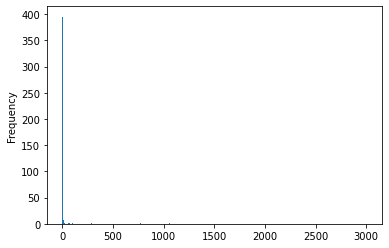

In [ ]:
df.width.value_counts().sort_index().plot.hist(bins=1200)

In [ ]:
df.height.median(), df.width.median()

(260.0, 256.0)

In [ ]:
df.height.mean(), df.width.mean()

(671.1508219335556, 583.2750890907001)

In [ ]:
df.height.std(), df.width.std()

(888.9700429119756, 874.1360928347998)

In [ ]:
df.describe()

,resolutionUnit,sensingmethod,height,width
count,1240.000000,425.000000,8699.000000,8699.000000
mean,3.051613,1.990588,671.150822,583.275089
std,14.600040,0.137037,888.970043,874.136093
min,2.000000,0.000000,64.000000,58.000000
25%,2.000000,2.000000,256.000000,256.000000
50%,2.000000,2.000000,260.000000,256.000000
75%,2.000000,2.000000,640.000000,480.000000
max,300.000000,2.000000,4608.000000,4240.000000


### **Create pixel histograms**
1. Convert a string representation of R pixels (df.R) list into list of strings (red_list = red.strip('][').split(', ')) (https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/)
2. Convert all strings in the list to integers (https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/)
3. Sum red pixels lists (R column) into one final list (red = df.R.sum())
4. Calculate number of pictures by counting the number of df columns (number_of_pictures = len(df))
5. Divide the red pixels list by the number of pictures
6. Create red histogram

In [ ]:
type(df.R)

pandas.core.series.Series

In [ ]:
df.R

0       [13318, 5107, 3702, 4388, 3777, 4177, 4849, 48...
1       [340, 62, 68, 67, 94, 109, 118, 124, 157, 192,...
2       [4, 0, 3, 1, 0, 1, 2, 5, 3, 5, 4, 6, 1, 4, 3, ...
3       [12, 4, 6, 16, 12, 16, 30, 27, 23, 30, 40, 42,...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
8694    [1175, 765, 858, 1051, 1276, 1322, 1524, 1642,...
8695    [5, 1, 2, 0, 2, 1, 4, 4, 5, 4, 10, 19, 37, 71,...
8696    [3348, 2183, 1554, 1171, 1097, 1007, 1019, 906...
8697    [294, 77, 72, 74, 107, 169, 155, 101, 89, 96, ...
8698    [101, 31, 58, 84, 112, 218, 333, 327, 343, 423...
Name: R, Length: 8699, dtype: object

In [ ]:
df.G

0       [6249, 5455, 3114, 2976, 3528, 3580, 4420, 451...
1       [3, 5, 4, 3, 7, 4, 8, 12, 19, 21, 22, 33, 34, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
8694    [213, 456, 639, 1157, 1208, 1520, 1863, 2045, ...
8695    [5, 1, 2, 0, 2, 2, 5, 4, 6, 2, 11, 22, 37, 65,...
8696    [5165, 2953, 1884, 1710, 1858, 1845, 1686, 160...
8697    [101, 52, 39, 37, 46, 48, 42, 55, 49, 71, 76, ...
8698    [25, 28, 39, 51, 77, 168, 220, 269, 254, 273, ...
Name: G, Length: 8699, dtype: object

In [ ]:
initial_R_list = df.R
print(initial_R_list[0])

[13318, 5107, 3702, 4388, 3777, 4177, 4849, 4888, 5515, 5765, 6251, 10736, 8186, 12523, 10406, 11331, 10795, 10687, 11187, 11718, 12056, 12414, 13043, 13379, 14227, 14392, 14910, 15380, 15378, 15680, 15756, 16862, 16949, 17089, 17988, 18436, 18306, 19009, 19455, 20752, 22024, 23262, 23797, 24184, 25452, 24899, 27384, 26943, 28819, 30548, 29950, 30715, 29047, 30864, 30461, 29965, 30412, 29507, 29390, 29004, 28859, 28922, 29439, 30190, 29602, 29977, 30270, 30038, 30479, 30844, 31085, 32703, 31644, 32528, 31699, 31695, 31916, 30802, 29366, 28616, 27431, 27507, 27580, 26969, 26918, 27111, 26408, 26270, 25328, 25387, 25395, 23857, 23535, 23301, 23355, 23134, 22736, 22891, 22155, 22181, 21638, 20737, 20586, 20238, 20179, 20183, 20528, 20283, 20320, 20347, 19848, 20058, 19681, 20211, 20794, 21130, 22512, 22496, 23267, 23316, 22525, 22537, 22590, 21852, 21544, 21864, 21702, 20756, 21561, 21041, 21128, 21223, 21171, 21281, 21232, 21094, 20778, 21251, 21224, 22016, 21905, 21248, 22252, 21614, 22

In [ ]:
initial_G_list = df.G
print(initial_G_list[0])

[6249, 5455, 3114, 2976, 3528, 3580, 4420, 4515, 4695, 4992, 5160, 5516, 5886, 6502, 7303, 11777, 9467, 13933, 11987, 12854, 12672, 12720, 13027, 13456, 13520, 14582, 14480, 15468, 15860, 16126, 16672, 16852, 17134, 17632, 17545, 17633, 18014, 17782, 19257, 19533, 20150, 20670, 19996, 20833, 21318, 22404, 22836, 23646, 24454, 25622, 26962, 27871, 29333, 31315, 32616, 32104, 32019, 32676, 32312, 31912, 33015, 31383, 31616, 32504, 31967, 34888, 33317, 33590, 33851, 31933, 32238, 30996, 30725, 30935, 31164, 31043, 31318, 30923, 31212, 31783, 30559, 30644, 29657, 29345, 28592, 28446, 28072, 28038, 26713, 26932, 26502, 26453, 26233, 25534, 25884, 25458, 25528, 25477, 24449, 23993, 23081, 22565, 22127, 22383, 22007, 21631, 22956, 22177, 22353, 23747, 23584, 23076, 24023, 23632, 25131, 25167, 26093, 27083, 27818, 29730, 30321, 30969, 33072, 33205, 35367, 36424, 34674, 35609, 31946, 31886, 29786, 30597, 30509, 26102, 22540, 22002, 21288, 21439, 21279, 21449, 21717, 21804, 23173, 23773, 25103, 

In [ ]:
print(list_of_R_strings)

['5634', '3357', '3197', '3209', '3132', '2988', '3040', '2692', '2338', '2395', '2063', '1874', '1695', '1571', '1437', '1294', '1248', '1245', '1278', '1235', '1214', '1274', '1157', '1218', '1073', '1015', '1058', '1031', '1063', '1152', '1040', '1026', '1022', '954', '1054', '1055', '1134', '1203', '1221', '1178', '1251', '1357', '1493', '1618', '1708', '1959', '2075', '2351', '2348', '2318', '2343', '2232', '1919', '1836', '1701', '1491', '1330', '1135', '1096', '995', '995', '837', '817', '751', '656', '594', '573', '506', '544', '533', '528', '539', '546', '547', '479', '491', '460', '509', '528', '491', '456', '455', '471', '465', '454', '406', '437', '396', '413', '375', '390', '396', '353', '376', '385', '331', '408', '378', '419', '418', '419', '444', '490', '523', '566', '519', '527', '610', '620', '713', '731', '895', '865', '1010', '973', '982', '1039', '1058', '1022', '956', '825', '732', '740', '756', '755', '805', '874', '946', '896', '960', '964', '958', '983', '905',

In [ ]:
print(list_of_G_strings)

['']


In [ ]:
df[6680:6685]

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,...,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod,height,width
6680,car2607,RGB,JPEG,"(277, 182)","[254, 71, 65, 79, 124, 107, 136, 143, 146, 180...","[1680, 531, 559, 606, 505, 589, 532, 577, 563,...","[813, 191, 255, 252, 348, 395, 396, 449, 464, ...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277,182
6681,car2608,RGB,JPEG,"(300, 225)","[298, 1005, 266, 770, 529, 755, 593, 510, 673,...","[33, 1055, 185, 678, 407, 461, 483, 565, 532, ...","[323, 957, 271, 719, 490, 518, 703, 436, 544, ...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,225
6682,car2609,L,JPEG,"(500, 334)","[5634, 3357, 3197, 3209, 3132, 2988, 3040, 269...",[],[],downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,334
6683,car2610,RGB,JPEG,"(300, 225)","[498, 204, 220, 275, 283, 314, 315, 358, 367, ...","[59, 122, 148, 174, 205, 203, 228, 238, 235, 2...","[914, 214, 293, 358, 376, 414, 481, 486, 551, ...",downloaded,0000:00:00 00:00:00,2.0,...,NaN,NaN,NIKON,E2500,100,24,"(56, 10)",NaN,300,225
6684,car2611,RGB,JPEG,"(259, 194)","[488, 111, 104, 91, 170, 157, 202, 186, 234, 2...","[307, 93, 98, 90, 151, 132, 175, 194, 223, 248...","[107, 16, 123, 34, 205, 128, 159, 177, 188, 23...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259,194


In [ ]:
R_pixels_list = list()
G_pixels_list = list()
B_pixels_list = list()
final_R_list = list()
final_G_list = list()
final_B_list = list()

for index, row in df.iterrows():
  try: 
    initial_R_list = row['R']
    initial_G_list = row['G']
    initial_B_list = row['B']
    list_of_R_strings = initial_R_list.strip('][').split(', ')
    list_of_G_strings = initial_G_list.strip('][').split(', ')
    list_of_B_strings = initial_B_list.strip('][').split(', ')
    list_of_R_ints = list(map(int, list_of_R_strings))
    list_of_G_ints = list(map(int, list_of_G_strings))
    list_of_B_ints = list(map(int, list_of_B_strings))
    final_R_list.append(list_of_R_ints)
    final_G_list.append(list_of_G_ints)
    final_B_list.append(list_of_B_ints)
  except:
    #TODO: inwestigate this 3 indexes: 6682, 6807, 6851
    print("wrong index: ", index)
    print(initial_R_list)
    print(initial_G_list)
    print(initial_B_list)
    # print(list_of_R_strings)
    # print(list_of_G_strings)
    # print(list_of_R_ints)
    # print(list_of_G_ints)

R_pixels_list = [sum(x) for x in zip(*final_R_list)]
G_pixels_list = [sum(x) for x in zip(*final_G_list)]
B_pixels_list = [sum(x) for x in zip(*final_B_list)]
print(type(G_pixels_list))
print(G_pixels_list)

wrong index:  6682
[5634, 3357, 3197, 3209, 3132, 2988, 3040, 2692, 2338, 2395, 2063, 1874, 1695, 1571, 1437, 1294, 1248, 1245, 1278, 1235, 1214, 1274, 1157, 1218, 1073, 1015, 1058, 1031, 1063, 1152, 1040, 1026, 1022, 954, 1054, 1055, 1134, 1203, 1221, 1178, 1251, 1357, 1493, 1618, 1708, 1959, 2075, 2351, 2348, 2318, 2343, 2232, 1919, 1836, 1701, 1491, 1330, 1135, 1096, 995, 995, 837, 817, 751, 656, 594, 573, 506, 544, 533, 528, 539, 546, 547, 479, 491, 460, 509, 528, 491, 456, 455, 471, 465, 454, 406, 437, 396, 413, 375, 390, 396, 353, 376, 385, 331, 408, 378, 419, 418, 419, 444, 490, 523, 566, 519, 527, 610, 620, 713, 731, 895, 865, 1010, 973, 982, 1039, 1058, 1022, 956, 825, 732, 740, 756, 755, 805, 874, 946, 896, 960, 964, 958, 983, 905, 818, 770, 704, 583, 444, 360, 340, 337, 274, 301, 300, 278, 283, 277, 339, 334, 432, 444, 403, 418, 397, 360, 434, 450, 443, 436, 423, 333, 314, 250, 245, 239, 232, 208, 169, 175, 158, 150, 151, 168, 157, 100, 80, 74, 56, 57, 56, 58, 45, 43, 28, 37

In [ ]:
number_of_pictures = len(df)
number_of_pictures

8699

In [ ]:
finalRedList = [x / number_of_pictures for x in R_pixels_list]
finalGreenList = [x / number_of_pictures for x in G_pixels_list]
finalBlueList = [x / number_of_pictures for x in B_pixels_list]
print(finalRedList)
print(finalGreenList)
print(finalBlueList)

[3738.897919301069, 1845.9391884124611, 1403.0836877802046, 1682.4174042993448, 1577.9681572594552, 1669.9779284975284, 1851.8079089550522, 1876.2238188297506, 2002.7376709966663, 2063.605012070353, 2171.678698701, 2247.786872054259, 2339.3841820898956, 2452.067479020577, 2542.5653523393494, 2652.7034141855383, 2787.1203586619154, 2857.2933670536845, 2960.8966547879068, 3039.8850442579605, 3112.3811932406024, 3207.885963903897, 3310.310955282216, 3401.165766180021, 3488.2203701574895, 3550.044028049201, 3632.89458558455, 3687.464306242097, 3763.605701804805, 3811.7313484308543, 3922.9519484998277, 3967.719163122198, 4028.5704103919993, 4027.146798482584, 4037.5346591562247, 4088.8467639958617, 4142.062880790895, 4161.5911024255665, 4186.638924014254, 4186.55466145534, 4205.896999655133, 4236.278192895735, 4214.35682262329, 4261.324520059777, 4286.996206460512, 4290.364294746522, 4348.871709391884, 4367.493045177606, 4383.688010116105, 4402.6283480859865, 4441.04563742959, 4477.46649040

In [ ]:
def getRed(R): return '#%02x%02x%02x'%(R,0,0)
def getGreen(G): return '#%02x%02x%02x'%(0,G,0)
def getBlue(B):return '#%02x%02x%02x'%(0,0,B)

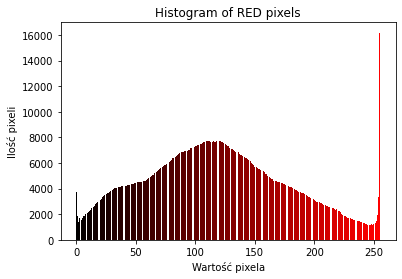

In [ ]:
plt.figure(0) # plots a figure to display RED Histogram
for i in range(0, 256):
  plt.title("Histogram of RED pixels")
  plt.xlabel('Wartość pixela')
  plt.ylabel('Ilość pixeli') 
  plt.bar(i, finalRedList[i], color = getRed(i)) #, alpha=0.3

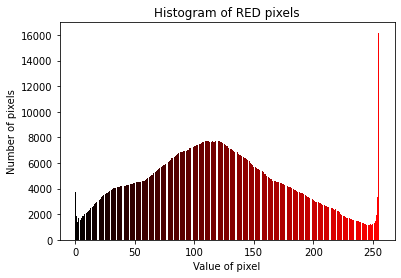

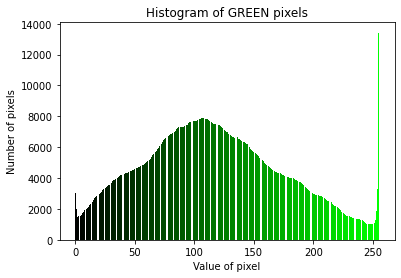

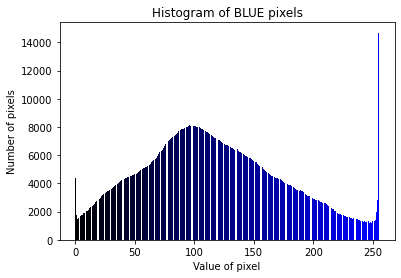

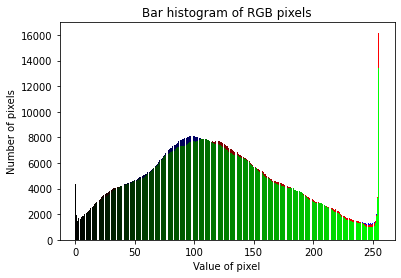

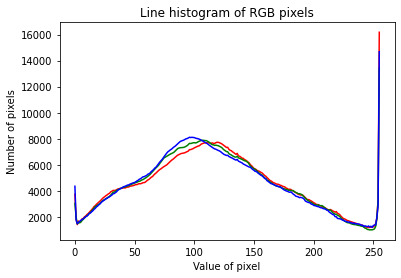

In [ ]:
red = finalRedList     # indicates Red
green = finalGreenList  # indicated Green
blue = finalBlueList   # indicates Blue

plt.figure(0) # plots a figure to display RED Histogram
for i in range(0, 256):
  plt.title("Histogram of RED pixels")
  plt.xlabel('Value of pixel') # Wartość pixela
  plt.ylabel('Number of pixels') # Ilość pixeli
  plt.bar(i, red[i], color = getRed(i)) #, alpha=0.3
plt.savefig(plots + '/red_bar_hist.jpg', dpi=600)

plt.figure(1) # plots a figure to display GREEN Histogram
for i in range(0, 256):
  plt.title("Histogram of GREEN pixels")
  plt.xlabel('Value of pixel') 
  plt.ylabel('Number of pixels')
  plt.bar(i, green[i], color = getGreen(i))
plt.savefig(plots + '/green_bar_hist.jpg', dpi=600)

plt.figure(2) # plots a figure to display BLUE Histogram
for i in range(0, 256):
  plt.title("Histogram of BLUE pixels")
  plt.xlabel('Value of pixel') 
  plt.ylabel('Number of pixels')
  plt.bar(i, blue[i], color = getBlue(i))
plt.savefig(plots + '/blue_bar_hist.jpg', dpi=600)

plt.figure(3) # plots a figure to display RGB Histogram
for i in range(0, 256):
  plt.title("Bar histogram of RGB pixels")
  plt.xlabel('Value of pixel') 
  plt.ylabel('Number of pixels')
  plt.bar(i, blue[i], color = getBlue(i))
  plt.bar(i, red[i], color = getRed(i))
  plt.bar(i, green[i], color = getGreen(i))
plt.savefig(plots + '/RGB_bar_hist.jpg', dpi=600)

plt.figure(4) # plots a figure to display RGB Histogram
plt.title("Line histogram of RGB pixels")
plt.xlabel('Value of pixel') 
plt.ylabel('Number of pixels')
plt.plot(red, color='red')
plt.plot(green, color='green')
plt.plot(blue, color='blue')
plt.savefig(plots + '/RGB_line_hist.jpg', dpi=600)

plt.show()

### Investigating outliers (grayscale photos)
- Creating histograms went smoothly, however, error happened in 3 cases: indexes 6682, 6807 and 6851. There was a lack of 'G' and 'B' row values ( just empty list)
- Answer comes: this 3 images has mode 'L', which means grayscale. That is why only one list of pixels histograms were loaded. We decide to leave this 3 images in our dataset (3/8800 = 0.00034 = 0,034%). 

In [ ]:
df.iloc[[6682, 6807, 6851],:]

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,...,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod,height,width
6682,car2609,L,JPEG,"(500, 334)","[5634, 3357, 3197, 3209, 3132, 2988, 3040, 269...",[],[],downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,334
6807,car2734,L,JPEG,"(800, 600)","[1112, 1615, 2108, 2202, 1989, 1794, 1621, 151...",[],[],downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800,600
6851,car2778,L,JPEG,"(392, 250)","[370, 76, 33, 41, 48, 45, 52, 80, 82, 102, 134...",[],[],downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,392,250


- car2778
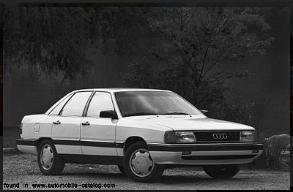

- car2734 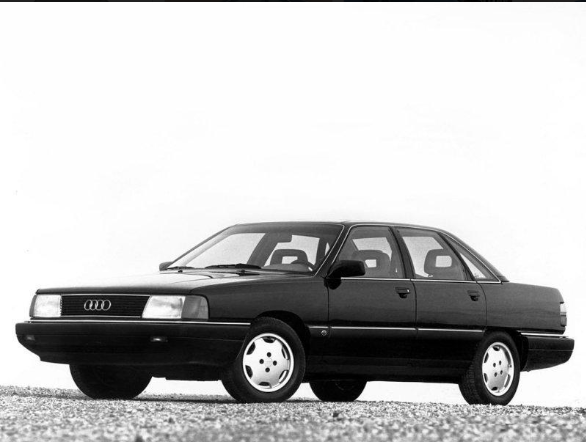

- car2609 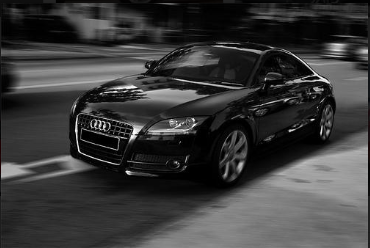

# Data Preprocessing:
- format bmp i gif -> JPEG 
- image height and width: cut or extend (to eg. 64x64 size)
### After EDA, we conclude that median value of image height is 256 pixels, and median value for image width is also 256. 3000 pictures out of 9000 (8800) (about 34%) falls under this condition. Thus, we decide to resize all the images to the size of 256x256 (rectangle shape). 
- About 1200 (1180) pictures has shape smaller then 256x256. In their case, because their will be resized to higher shape, the photo will be stretched. 
- Alternatively, if strething will fail, the black stipes will be added at the edges of the photo. 

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd + '/drive/MyDrive/2022_Projekt_badawczy/ZPD_SZUM/finaldata/car')  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['car2533.JPEG', 'car2534.JPEG', 'car2535.JPEG', 'car2536.JPEG', 'car2537.JPEG', 'car2538.JPEG', 'car2539.JPEG', 'car2540.JPEG', 'car2541.JPEG', 'car2542.JPEG', 'car2543.JPEG', 'car2544.JPEG', 'car2545.JPEG', 'car2546.JPEG', 'car2547.JPEG', 'car2548.JPEG', 'car2549.JPEG', 'car2550.JPEG', 'car2551.JPEG', 'car2552.JPEG', 'car2553.JPEG', 'car2554.JPEG', 'car2555.JPEG', 'car2556.JPEG', 'car2557.JPEG', 'car2558.JPEG', 'car2559.JPEG', 'car2560.JPEG', 'car2561.JPEG', 'car2562.JPEG', 'car2563.JPEG', 'car2564.JPEG', 'car2565.JPEG', 'car2566.JPEG', 'car2567.JPEG', 'car2568.JPEG', 'car2569.JPEG', 'car2570.JPEG', 'car2571.JPEG', 'car2572.JPEG', 'car2573.JPEG', 'car2574.JPEG', 'car2575.JPEG', 'car2576.JPEG', 'car2577.JPEG', 'car2578.JPEG', 'car2579.JPEG', 'car2580.JPEG', 'car2581.JPEG', 'car2582.JPEG', 'car2583.JPEG', 'car2584.JPEG', 'car2585.JPEG', 'car2586.JPEG', 'car2587.JPEG', 'car2588.JPEG', 'car2589.JPEG', 'car2590.JPEG', 'car2591.JPEG', 'car2592.JPEG', 'car2593.JPEG', 'c

Case of image resizing:

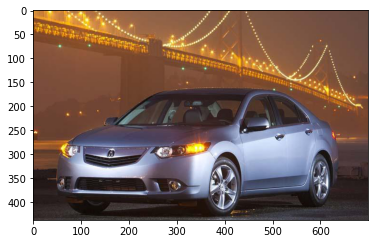

In [ ]:
#trying to load this picture
#Image cannot be found:
#FileNotFoundError: [Errno 2] No such file or directory: 
#'/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/finaldata/car/car3532.jpg'
# ANSWER: I need to provided .JPEG with capital letters at the end of the file name
image2 = Image.open(final_data + 'car/car3532.JPEG')
plt.imshow(image2);

In [ ]:
print(image2.size)
img_resized = image2.resize((256,256))
print(img_resized.size)

(700, 438)
(256, 256)


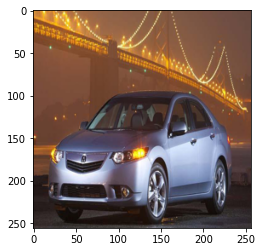

In [ ]:
plt.imshow(img_resized);

Case of image stretching:

In [ ]:
df[df['size'] < (256,256)] 
#bus1100, bus1101 - 64x64
#truck157 - 250x166
#truck160 - 120x120

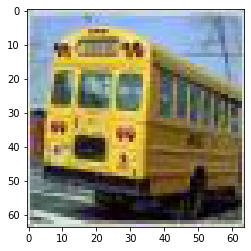

(64, 64)
(256, 256)


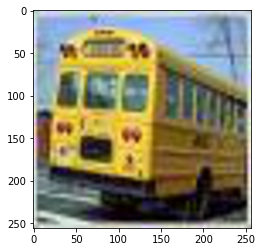

In [ ]:
#in case of the bus, the streching is hard to see by eye
image2 = Image.open(final_data + 'bus/bus1100.JPEG')
plt.imshow(image2)
plt.show()
print(image2.size)
img_resized = image2.resize((256,256))
print(img_resized.size)
plt.imshow(img_resized)
plt.show()

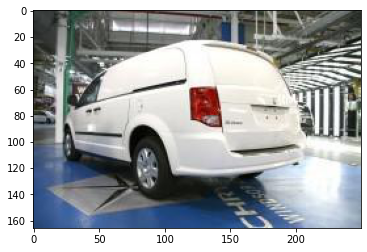

(250, 166)
(256, 256)


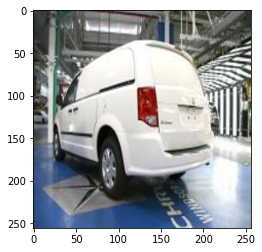

In [ ]:
#for this car, streching works fine
image2 = Image.open(final_data + 'truck/truck157.JPEG')
plt.imshow(image2)
plt.show()
print(image2.size)
img_resized = image2.resize((256,256))
print(img_resized.size)
plt.imshow(img_resized)
plt.show()

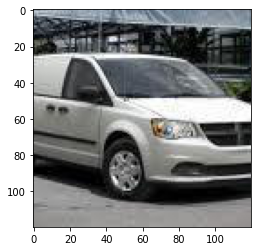

(120, 120)
(256, 256)


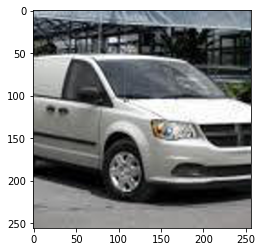

In [ ]:
# and for this car, streching works fine too
image2 = Image.open(final_data + 'truck/truck160.JPEG')
plt.imshow(image2)
plt.show()
print(image2.size)
img_resized = image2.resize((256,256))
print(img_resized.size)
plt.imshow(img_resized)
plt.show()

# Automatic image preprocessing
Preprocessed data will be saved in "preprocesessed" folder. 

In [ ]:
df

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,...,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod,height,width
0,motorcycle0,RGB,JPEG,"(2976, 2976)","[13318, 5107, 3702, 4388, 3777, 4177, 4849, 48...","[6249, 5455, 3114, 2976, 3528, 3580, 4420, 451...","[9755, 3928, 2417, 2805, 4408, 4082, 4301, 482...",collected,2022:03:14 17:13:44,2.0,...,"(233, 100)","(169, 100)",Xiaomi,Mi Note 3,138,24,"(3820, 1000)",2.0,2976,2976
1,motorcycle1,RGB,JPEG,"(3024, 3024)","[340, 62, 68, 67, 94, 109, 118, 124, 157, 192,...","[3, 5, 4, 3, 7, 4, 8, 12, 19, 21, 22, 33, 34, ...","[27, 7, 2, 5, 7, 7, 14, 18, 15, 31, 27, 32, 49...",collected,2022:03:14 14:49:39,2.0,...,"(544, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
2,motorcycle2,RGB,JPEG,"(3024, 3024)","[4, 0, 3, 1, 0, 1, 2, 5, 3, 5, 4, 6, 1, 4, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",collected,2022:03:14 14:49:32,2.0,...,"(574, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
3,motorcycle3,RGB,JPEG,"(3024, 3024)","[12, 4, 6, 16, 12, 16, 30, 27, 23, 30, 40, 42,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 2, ...",collected,2022:03:14 14:49:38,2.0,...,"(546, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
4,motorcycle4,RGB,JPEG,"(3024, 3024)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",collected,2022:03:14 14:49:35,2.0,...,"(454, 100)","(252, 100)",samsung,SM-G965F,64,0,"(430, 100)",NaN,3024,3024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,truck1088,RGB,JPEG,"(1024, 768)","[1175, 765, 858, 1051, 1276, 1322, 1524, 1642,...","[213, 456, 639, 1157, 1208, 1520, 1863, 2045, ...","[5721, 2342, 3063, 3450, 3529, 3870, 4005, 400...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024,768
8695,truck1089,RGB,JPEG,"(434, 326)","[5, 1, 2, 0, 2, 1, 4, 4, 5, 4, 10, 19, 37, 71,...","[5, 1, 2, 0, 2, 2, 5, 4, 6, 2, 11, 22, 37, 65,...","[1, 0, 4, 1, 4, 0, 0, 2, 6, 5, 10, 18, 46, 75,...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434,326
8696,truck1090,RGB,JPEG,"(720, 313)","[3348, 2183, 1554, 1171, 1097, 1007, 1019, 906...","[5165, 2953, 1884, 1710, 1858, 1845, 1686, 160...","[2973, 1779, 1343, 1253, 992, 898, 883, 667, 6...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,313
8697,truck1091,RGB,JPEG,"(380, 228)","[294, 77, 72, 74, 107, 169, 155, 101, 89, 96, ...","[101, 52, 39, 37, 46, 48, 42, 55, 49, 71, 76, ...","[132, 32, 46, 37, 35, 36, 43, 45, 32, 51, 45, ...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380,228


##### Initialize temporary df to work on a copy of the document

In [ ]:
tmp_df = df.copy()

In [ ]:
tmp_df

,name,mode,format,size,R,G,B,source,datetime,resolutionUnit,...,brightness,aperture,phonemake,phonemodel,ISOspeedratings,flash,focallength,sensingmethod,height,width
0,motorcycle0,RGB,JPEG,"(2976, 2976)","[13318, 5107, 3702, 4388, 3777, 4177, 4849, 48...","[6249, 5455, 3114, 2976, 3528, 3580, 4420, 451...","[9755, 3928, 2417, 2805, 4408, 4082, 4301, 482...",collected,2022:03:14 17:13:44,2.0,...,"(233, 100)","(169, 100)",Xiaomi,Mi Note 3,138,24,"(3820, 1000)",2.0,2976,2976
1,motorcycle1,RGB,JPEG,"(3024, 3024)","[340, 62, 68, 67, 94, 109, 118, 124, 157, 192,...","[3, 5, 4, 3, 7, 4, 8, 12, 19, 21, 22, 33, 34, ...","[27, 7, 2, 5, 7, 7, 14, 18, 15, 31, 27, 32, 49...",collected,2022:03:14 14:49:39,2.0,...,"(544, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
2,motorcycle2,RGB,JPEG,"(3024, 3024)","[4, 0, 3, 1, 0, 1, 2, 5, 3, 5, 4, 6, 1, 4, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",collected,2022:03:14 14:49:32,2.0,...,"(574, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
3,motorcycle3,RGB,JPEG,"(3024, 3024)","[12, 4, 6, 16, 12, 16, 30, 27, 23, 30, 40, 42,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 2, ...",collected,2022:03:14 14:49:38,2.0,...,"(546, 100)","(252, 100)",samsung,SM-G965F,50,0,"(430, 100)",NaN,3024,3024
4,motorcycle4,RGB,JPEG,"(3024, 3024)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",collected,2022:03:14 14:49:35,2.0,...,"(454, 100)","(252, 100)",samsung,SM-G965F,64,0,"(430, 100)",NaN,3024,3024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,truck1088,RGB,JPEG,"(1024, 768)","[1175, 765, 858, 1051, 1276, 1322, 1524, 1642,...","[213, 456, 639, 1157, 1208, 1520, 1863, 2045, ...","[5721, 2342, 3063, 3450, 3529, 3870, 4005, 400...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024,768
8695,truck1089,RGB,JPEG,"(434, 326)","[5, 1, 2, 0, 2, 1, 4, 4, 5, 4, 10, 19, 37, 71,...","[5, 1, 2, 0, 2, 2, 5, 4, 6, 2, 11, 22, 37, 65,...","[1, 0, 4, 1, 4, 0, 0, 2, 6, 5, 10, 18, 46, 75,...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434,326
8696,truck1090,RGB,JPEG,"(720, 313)","[3348, 2183, 1554, 1171, 1097, 1007, 1019, 906...","[5165, 2953, 1884, 1710, 1858, 1845, 1686, 160...","[2973, 1779, 1343, 1253, 992, 898, 883, 667, 6...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,313
8697,truck1091,RGB,JPEG,"(380, 228)","[294, 77, 72, 74, 107, 169, 155, 101, 89, 96, ...","[101, 52, 39, 37, 46, 48, 42, 55, 49, 71, 76, ...","[132, 32, 46, 37, 35, 36, 43, 45, 32, 51, 45, ...",downloaded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380,228


In [ ]:
type(tmp_df.source[tmp_df.name == 'bus30'].item())

str

In [ ]:
class_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']
images_names_list = list()
images_modes_list = list()
images_formats_list = list()
images_sizes_list = list()
images_heights_list = list()
images_widths_list = list()
images_red_pixels_list = list()
images_green_pixels_list = list()
images_blue_pixels_list = list()
images_sources_list = list()
metadata_datetime_list = list()
metadata_resolutionunit_list = list()
metadata_Xresolution_list = list()
metadata_Yresolution_list = list()
metadata_brightnessvalue_list = list()
metadata_aperturevalue_list = list()
metadata_phonemake_list = list()
metadata_phonemodel_list = list()
metadata_ISOspeedratings_list = list()
metadata_flash_list = list()
metadata_focallength_list = list()
metadata_sensingmethod_list = list()

for class_name in class_names:
  #paths
  imageFinalFilePath = Path.joinpath(final_data_dir, class_name)
  imagePreprocessedFilePath = Path(preprocessed_data, class_name)
  #collect images from first source
  for imageid, imagePath in enumerate(list(imageFinalFilePath.glob('*.*'))):
    #each class starts id from 0
    # load image
    image = Image.open(imagePath) 
    # PERFORM RESIZING
    img_resized = image.resize((256,256))
    image = img_resized
    # save in the JPEG format
    #/content/drive/MyDrive/2022_Projekt_badawczy/ZPD_SZUM/finaldata/motorcycle/motorcycle1537.JPEG
    str_to_split = "/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/finaldata/" + class_name + "/"
    image_name = str(imagePath).split(str_to_split)[1]
    image_name = image_name.split('.')[0]
    image_mode = image.mode
    if image_mode == 'RGBA':
      image = image.convert(mode='RGB')
      image_mode = image.mode
    image_format = 'JPEG'
    image_size = image.size
    image_height = image.size[0]
    image_width = image.size[1]
    #image source
    image_source = tmp_df.source[tmp_df.name == image_name].item()
    pixels = image.histogram()
    red_pixels = pixels[0:256]      # indicates Red
    green_pixels = pixels[256:512]  # indicated Green
    blue_pixels = pixels[512:768]   # indicates Blue
    #print(image_name, image_mode, image_format, image_size, red_pixels, green_pixels, blue_pixels)
    #SAVE IMAGES DATA
    images_names_list.append(image_name)
    images_modes_list.append(image_mode)
    images_formats_list.append(image_format)
    images_sizes_list.append(image_size)
    images_heights_list.append(image_height)
    images_widths_list.append(image_width)
    images_red_pixels_list.append(red_pixels)
    images_green_pixels_list.append(green_pixels)
    images_blue_pixels_list.append(blue_pixels)
    images_sources_list.append(image_source)
    
    #EXTRACT METADATA FROM TAGS
    img_exif = image.getexif()
    if bool(img_exif) == False:
      metadata_datetime = ''
      metadata_resolutionunit = ''
      metadata_Xresolution = ''
      metadata_Yresolution = ''
      metadata_brightnessvalue = ''
      metadata_aperturevalue = ''
      metadata_phonemake = ''
      metadata_phonemodel = ''
      metadata_ISOspeedratings = ''
      metadata_flash = ''
      metadata_focallength = ''
      metadata_sensingmethod = ''
      #print('Sorry, image has no exif data.')
    else:
      for key, val in img_exif.items():
        #datetime
        if key == 306:
          metadata_datetime = val
        if 306 not in img_exif.keys():
          metadata_datetime = ''
        #metadata_resolutionunit
        if key == 296:
          metadata_resolutionunit = val
        if 296 not in img_exif.keys():
          metadata_resolutionunit = ''
        #metadata_Xresolution
        if key == 282:
          metadata_Xresolution = val
        if 282 not in img_exif.keys():
          metadata_Xresolution = ''
        #metadata_Yresolution
        if key == 283:
          metadata_Yresolution = val
        if 283 not in img_exif.keys():
          metadata_Yresolution = ''
        #metadata_brightnessvalue
        if key == 37379:
          metadata_brightnessvalue = val
        if 37379 not in img_exif.keys():
          metadata_brightnessvalue = ''
        #metadata_aperturevalue
        if key == 37378:
          metadata_aperturevalue = val
        if 37378 not in img_exif.keys():
          metadata_aperturevalue = ''
        #metadata_phonemake
        if key == 271:
          metadata_phonemake = val
        if 271 not in img_exif.keys():
          metadata_phonemake = ''
        #metadata_phonemodel
        if key == 272:
          metadata_phonemodel = val
        if 272 not in img_exif.keys():
          metadata_phonemodel = ''
        #metadata_ISOspeedratings
        if key == 34855:
          metadata_ISOspeedratings = val
        if 34855 not in img_exif.keys():
          metadata_ISOspeedratings = ''
        #metadata_flash
        if key == 37385:
          metadata_flash = val
        if 37385 not in img_exif.keys():
          metadata_flash = ''
        #metadata_focallength
        if key == 37386:
          metadata_focallength = val
        if 37386 not in img_exif.keys():
          metadata_focallength = ''
        #metadata_sensingmethod
        if key == 41495:
          metadata_sensingmethod = val
        if 41495 not in img_exif.keys():
          metadata_sensingmethod = ''         
    #SAVE IMAGES METADATA
    metadata_datetime_list.append(metadata_datetime)
    metadata_resolutionunit_list.append(metadata_resolutionunit)
    metadata_Xresolution_list.append(metadata_Xresolution)
    metadata_Yresolution_list.append(metadata_Yresolution)
    metadata_brightnessvalue_list.append(metadata_brightnessvalue)
    metadata_aperturevalue_list.append(metadata_aperturevalue)
    metadata_phonemake_list.append(metadata_phonemake)
    metadata_phonemodel_list.append(metadata_phonemodel)
    metadata_ISOspeedratings_list.append(metadata_ISOspeedratings)
    metadata_flash_list.append(metadata_flash)
    metadata_focallength_list.append(metadata_focallength)
    metadata_sensingmethod_list.append(metadata_sensingmethod)
    #SAVE IMAGE
    #image.save(Path.joinpath(imagePreprocessedFilePath, f'{image_name}.{str(image_format)}'), format=image_format)
    #optionally - show image
    if imageid % 250 == 0:
      plt.imshow(image)
      plt.show()
    #CLOSE IMAGE (necessary to release memory, because load() function were not called)
    image.close()

#after all iterations
data_dictionary = {'name': images_names_list, 
                   'mode': images_modes_list, 
                   'format': images_formats_list, 
                   'img_size': images_sizes_list, 
                   'height': images_heights_list, 
                   'width': images_widths_list,
                   'R': images_red_pixels_list, 
                   'G': images_green_pixels_list, 
                   'B': images_blue_pixels_list, 
                   'source': images_sources_list,
                   'datetime': metadata_datetime_list, 
                   'resolutionUnit': metadata_resolutionunit_list, 
                   'Xresolution': metadata_Xresolution_list, 
                   'Yresolution': metadata_Yresolution_list, 
                   'brightness': metadata_brightnessvalue_list, 
                   'aperture': metadata_aperturevalue_list, 
                   'phonemake': metadata_phonemake_list, 
                   'phonemodel': metadata_phonemodel_list, 
                   'ISOspeedratings': metadata_ISOspeedratings_list, 
                   'flash': metadata_flash_list, 
                   'focallength': metadata_focallength_list, 
                   'sensingmethod': metadata_sensingmethod_list}
preprocessed_df = pd.DataFrame(data_dictionary)
display(preprocessed_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#save to csv file
preprocessed_df.to_csv(preprocessed_data + 'preprocesseddata.csv')

Image preprocessing works well, but there are some problems with preprocessed_df, so we will not use it. 

# The rest of the code (data augmentation and division into train/val/test set) will be held in the separate notebook. 

# -------------------------------------------------
# Próbne kody:

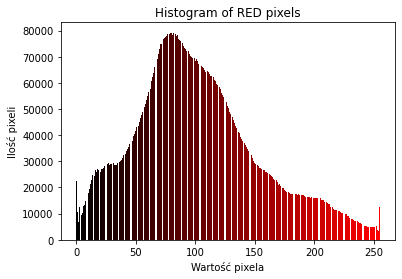

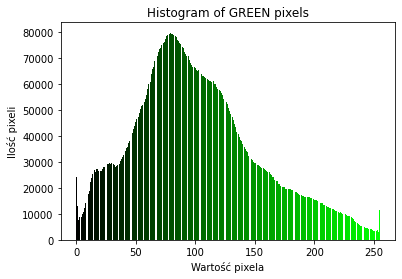

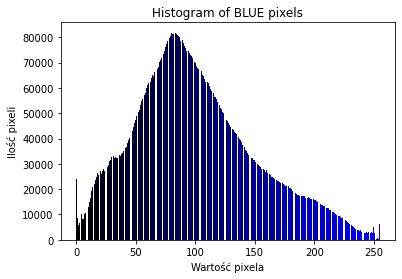

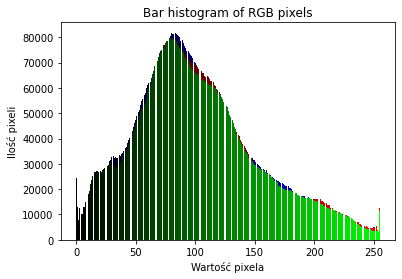

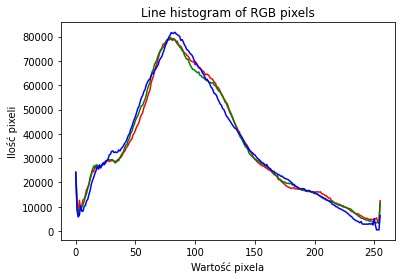

In [ ]:
hst = image.histogram()
red = hst[0:256]      # indicates Red
green = hst[256:512]  # indicated Green
blue = hst[512:768]   # indicates Blue

plt.figure(0) # plots a figure to display RED Histogram
for i in range(0, 256):
  plt.title("Histogram of RED pixels")
  plt.xlabel('Wartość pixela')
  plt.ylabel('Ilość pixeli') 
  plt.bar(i, red[i], color = getRed(i)) #, alpha=0.3

plt.figure(1) # plots a figure to display GREEN Histogram
for i in range(0, 256):
  plt.title("Histogram of GREEN pixels")
  plt.xlabel('Wartość pixela')
  plt.ylabel('Ilość pixeli') 
  plt.bar(i, green[i], color = getGreen(i))

plt.figure(2) # plots a figure to display BLUE Histogram
for i in range(0, 256):
  plt.title("Histogram of BLUE pixels")
  plt.xlabel('Wartość pixela')
  plt.ylabel('Ilość pixeli') 
  plt.bar(i, blue[i], color = getBlue(i))

plt.figure(3) # plots a figure to display RGB Histogram
for i in range(0, 256):
  plt.title("Bar histogram of RGB pixels")
  plt.xlabel('Wartość pixela')
  plt.ylabel('Ilość pixeli') 
  plt.bar(i, blue[i], color = getBlue(i))
  plt.bar(i, red[i], color = getRed(i))
  plt.bar(i, green[i], color = getGreen(i))

plt.figure(4) # plots a figure to display RGB Histogram
plt.title("Line histogram of RGB pixels")
plt.xlabel('Wartość pixela')
plt.ylabel('Ilość pixeli') 
plt.plot(red, color='red')
plt.plot(green, color='green')
plt.plot(blue, color='blue')

plt.show()

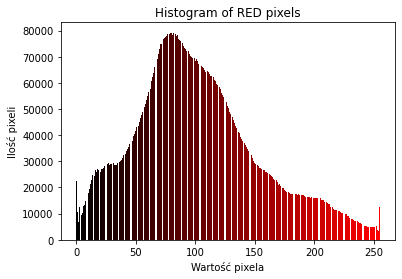

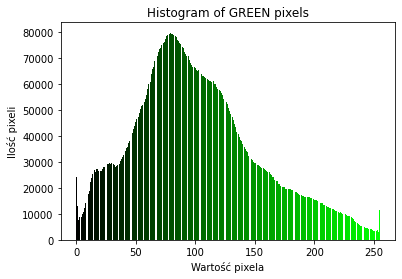

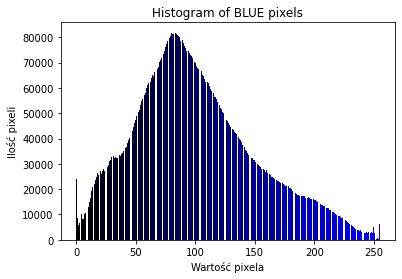

In [ ]:
class_names = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
for class_name in class_names:
  imageid = 0
  #image = collected_data_dir+class_name#.glob('*/*.jpg')
  imageCollectedFilePath = Path.joinpath(collected_data_dir, class_name)
  imageDownloadedFilePath = Path.joinpath(downloaded_data_dir, class_name)
  imageFinalFilePath = Path.joinpath(final_data_dir, class_name)
  #print(imageFinalFilePath)
  #print(imageFilePath)
  for imagePath in list(imageCollectedFilePath.glob('*.*')):
    #print(imageid)
    #print(imagePath)
    image = Image.open(imagePath) # ładuje zdjęcie (read_image)
    # save in the same format
    #print(image.format)
    #print(Path.joinpath(imageFinalFilePath, f'{class_name + str(imageid)}.{str(image.format)}'))
    image_name = class_name + str(imageid)
    image_mode = image.mode
    image_format = image.format
    image_size = image.size
    #print(image_name, image_mode, image_format, image_size)
    #SAVE IMAGE
    #image.save(Path.joinpath(imageFinalFilePath, f'{image_name}.{str(image_format)}'), format=image_format)
    #remember to increment image_id
    imageid += 1

    hst = image.histogram()
    red = hst[0:256]      # indicates Red
    green = hst[256:512]  # indicated Green
    blue = hst[512:768]   # indicates Blue
    
    plt.figure(0) # plots a figure to display RED Histogram
    for i in range(0, 256):
      plt.title("Histogram of RED pixels")
      plt.xlabel('Wartość pixela')
      plt.ylabel('Ilość pixeli') 
      plt.bar(i, red[i], color = getRed(i)) #, alpha=0.3
    
    plt.figure(1) # plots a figure to display GREEN Histogram
    for i in range(0, 256):
      plt.title("Histogram of GREEN pixels")
      plt.xlabel('Wartość pixela')
      plt.ylabel('Ilość pixeli') 
      plt.bar(i, green[i], color = getGreen(i))
    
    plt.figure(2) # plots a figure to display BLUE Histogram
    for i in range(0, 256):
      plt.title("Histogram of BLUE pixels")
      plt.xlabel('Wartość pixela')
      plt.ylabel('Ilość pixeli') 
      plt.bar(i, blue[i], color = getBlue(i))
    
    plt.show()

    # r, g, b = image.split()
    # print("histogram length: ", len(image.histogram()))
    # #display(r.histogram())
    # plt.hist(image.histogram(), bins=None)
    # #optionally - show image
    # #plt.imshow(image)
    # plt.show()
    break
    if imageid == 2:
      break
  break

In [ ]:
256*3

768

In [ ]:
r, g, b = img.split()
len(r.histogram())
### 256 ###
 
r.histogram()

image:  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2976x2976 at 0x7FC4D11734D0>
JPEG
RGB
(2976, 2976)
image2:  <PIL.Image.Image image mode=RGB size=2976x2976 at 0x7FC4D1146E90>
None
RGB
(2976, 2976)


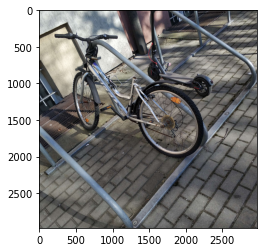

In [ ]:
class_names = ['bicycle', 'bus', 'car', 'motorcycle', 'truck']
for class_name in class_names:
  #image = collected_data_dir+class_name#.glob('*/*.jpg')
  imageFilePath = Path.joinpath(collected_data_dir, class_name)
  #print(imageFilePath)
  for imagePath in list(imageFilePath.glob('*.*')):
    #print(imagePath)
    image = Image.open(imagePath) # ładuje zdjęcie (read_image)
    #todo: imageid
    print("image: ", image)
    print(image.format)
    print(image.mode)
    print(image.size)
    data = np.asarray(image)
    #print("data: ", data)
    # summarize shape
    #print("data shape: ", data.shape)
    # create Pillow image
    image2 = Image.fromarray(data)
    print("image2: ", image2)
    # summarize image details
    print(image2.format)
    print(image2.mode)
    print(image2.size)
    plt.imshow(image)
    plt.show()
    break
  break

In [ ]:
from os import listdir
# load all images in a directory
loaded_images = list()
for filename in listdir(collected_data + '/bicycle'):
  # load image
  img_data = image.imread(collected_data + '/bicycle/' + filename)
  #print(img_data)
  # store loaded image
  loaded_images.append(img_data)
  print('> loaded %s %s' % (filename, img_data.shape))
  break

> loaded IMG_20220312_123458.jpg (2976, 2976, 3)


In [ ]:
filename

'IMG_20220312_123458.jpg'